In [1]:
from spektral.layers import GraphConv
from tensorflow.keras.layers import Input, Dense, Lambda, Masking
from tensorflow.keras.backend import gather, squeeze
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


## First trail

In [2]:
class GraphicEncoder():
    def __init__(self, F):
        self.model = self.build_model(F)

    def build_model(self,F):
        X_in = Input(shape=(F,), name='X_in')
        A_in = Input(shape=(None,), name='A_in')
        RL_indice = Input(shape=(None,),batch_size = 1, name='RL_indice',dtype='int32')

        
        ### Graphic convolution
        
        x = GraphConv(32, activation='relu',name='gcn1')([X_in, A_in])
        x = GraphConv(32, activation='relu',name='gcn2')([x, A_in])
        x = Lambda(lambda x: gather(x,RL_indice),name='slice')(x)
        
        x = Lambda(lambda x: squeeze(x,0),name='squeeze')(x)
        
        ### Policy network
        
        x = Dense(32,activation='relu',name='policy_1')(x)
        x = Dense(16,activation='relu',name='policy_2')(x)
        x = Dense(3, activation='relu',name='policy_3')(x)
        
        
        model = Model(inputs = [X_in,A_in,RL_indice], outputs=x)
        print(model.summary())
        return model
    
    
feature_size = 9
rl_model = GraphicEncoder(feature_size)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_in (InputLayer)               [(None, 9)]          0                                            
__________________________________________________________________________________________________
A_in (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
gcn1 (GraphConv)                (None, 32)           320         X_in[0][0]                       
                                                                 A_in[0][0]                       
__________________________________________________________________________________________________
gcn2 (GraphConv)                (None, 32)           1056        gcn1[0][0]                   

In [3]:
from gym.spaces.box import Box
from gym.spaces import Discrete
from gym.spaces.dict import Dict
import numpy as np

In [4]:
from gym.spaces.box import Box
from gym.spaces import Discrete
from gym.spaces.dict import Dict
import numpy as np
F = 9
N = 40

states = Box(low=-np.inf, high=np.inf, shape=(N,F), dtype=np.float32)
adjacency = Box(low=0, high=1, shape = (N,N), dtype=np.int32)
mask = Box(low=0, high=1, shape = (N,), dtype=np.int32)

obs_space = Dict({'states':states,'adjacency':adjacency,'mask':mask})
act_space = Box(low=0, high=1, shape = (N,), dtype=np.int32)

## Second trail

In [5]:
from spektral.layers import GraphConv
from tensorflow.keras.layers import Input, Dense, Lambda, Multiply, Reshape, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

class GraphicPolicy(TFModelV2):
    def __init__(self, N,F, obs_space, action_space, num_outputs=3, model_config=None, name='graphic_policy'):
        super(GraphicPolicy,self).__init__(obs_space, action_space, num_outputs, model_config, name)
        self.base_model = self.build_model(N,F,num_outputs)
        self.register_variables(self.base_model.variables)
        
    def build_model(self,N,F,num_outputs):
        X_in = Input(shape=(N,F), name='X_in')
        A_in = Input(shape=(N,N), name='A_in')
        RL_indice = Input(shape=(N), name='mask')
        
        ### Graphic convolution
        
        x = GraphConv(32, activation='relu',name='gcn1')([X_in, A_in])
        x = GraphConv(32, activation='relu',name='gcn2')([x, A_in])

        
        ### Policy network
        
        x1 = Dense(32,activation='relu',name='policy_1')(x)
        x2 = Dense(16,activation='relu',name='policy_2')(x1)
        
    
        ###  Action and filter
        x3 = Dense(num_outputs, activation='relu',name='policy_3')(x2)
        mask = Reshape((N,1),name='expend_dim')(RL_indice)
        out = Multiply(name='filter')([x3,mask])
        
        
        #### Value out
        x2 = Flatten(name='flatten')(x2)
        value = Dense(1,activation='linear',name='value_out')(x2)
        

        model = Model(inputs = [X_in,A_in,RL_indice], outputs=[out,value])
        print(model.summary())
        return model
    
    def forward(self, input_dict, state, seq_lens):
        obs = input_dic['obs']
        model_out, self._value_out = self.base_model({X_in:obs['states'],A_in:obs['adjacency'],RL_indice:obs['mask']})        
        return model_out,state
        
    def value_function(self):
        return tf.reshape(self._value_out, [-1])
    
model_config = {}
rl_model = GraphicPolicy(N,F, obs_space, act_space)

NameError: name 'TFModelV2' is not defined

## Test for the model + agents

In [6]:
from tensorflow.keras.utils import plot_model

In [14]:
class GraphicQNetworkKeras():
    def __init__(self, N,F, obs_space, action_space, num_outputs=3, model_config=None, name='graphic_policy_keras'):
        self.obs_space = obs_space
        self.action_space = action_space
        self.num_outputs = num_outputs
        self.name = name
        self.base_model = self.build_model(N,F,num_outputs)

    def build_model(self,N,F,num_outputs):
        
        X_in = Input(shape=(N,F), name='X_in')
        x = Dense(32,activation='relu',name='encoder_1')(X_in)
        x = Dense(32,activation='relu',name='encoder_2')(x)
        
        A_in = Input(shape=(N,N), name='A_in')
        RL_indice = Input(shape=(N), name='mask')

        ### Graphic convolution

        x = GraphConv(32, activation='relu',name='gcn1')([x, A_in])
#         x = GraphConv(32, activation='relu',name='gcn2')([x, A_in])

        ### Policy network
        x1 = Dense(32,activation='relu',name='policy_1')(x)
        
        x2 = Dense(16,activation='relu',name='policy_2')(x1)

        ###  Action and filter
        x3 = Dense(num_outputs, activation='linear',name='policy_3')(x2)
        mask = Reshape((N,1),name='expend_dim')(RL_indice)
        qout = Multiply(name='filter')([x3,mask])

        model = Model(inputs = [X_in,A_in,RL_indice], outputs=[qout])
        print(model.summary())
        return model
rl_model = GraphicQNetworkKeras(N,F, obs_space, act_space)

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_in (InputLayer)               [(None, 40, 9)]      0                                            
__________________________________________________________________________________________________
encoder_1 (Dense)               (None, 40, 32)       320         X_in[0][0]                       
__________________________________________________________________________________________________
encoder_2 (Dense)               (None, 40, 32)       1056        encoder_1[0][0]                  
__________________________________________________________________________________________________
A_in (InputLayer)               [(None, 40, 40)]     0                                            
____________________________________________________________________________________________

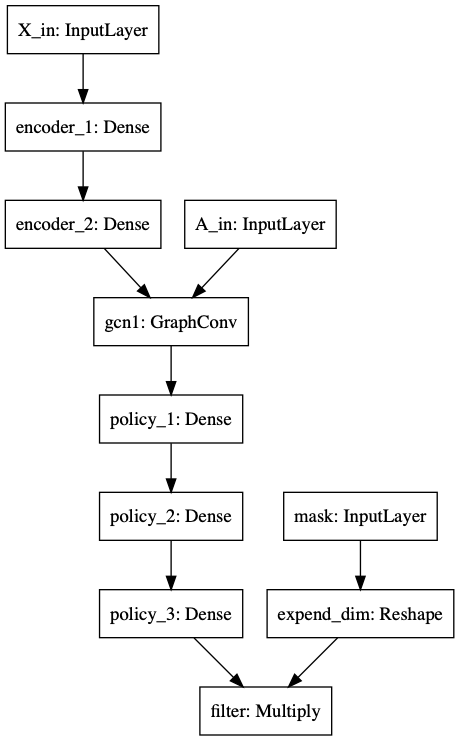

In [11]:
plot_model(rl_model.base_model)

### LSTM Fusion

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_in (InputLayer)               [(None, 40, 9)]      0                                            
__________________________________________________________________________________________________
encoder_1 (Dense)               (None, 40, 32)       320         X_in[0][0]                       
__________________________________________________________________________________________________
encoder_2 (Dense)               (None, 40, 32)       1056        encoder_1[0][0]                  
__________________________________________________________________________________________________
masking_1 (Masking)             (None, 40, 32)       0           encoder_2[0][0]                  
____________________________________________________________________________________________

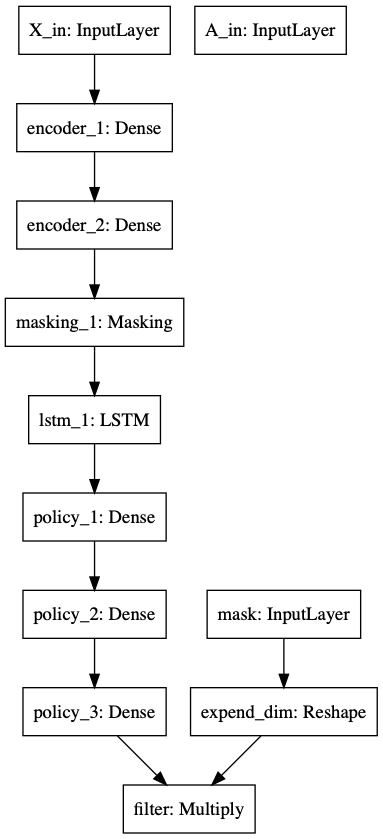

In [12]:
from gym.spaces.box import Box
from gym.spaces import Discrete
from gym.spaces.dict import Dict
import numpy as np
F = 9
N = 40

states = Box(low=-np.inf, high=np.inf, shape=(N,F), dtype=np.float32)
adjacency = Box(low=0, high=1, shape = (N,N), dtype=np.int32)
mask = Box(low=0, high=1, shape = (N,), dtype=np.int32)

obs_space = Dict({'states':states,'adjacency':adjacency,'mask':mask})
act_space = Box(low=0, high=1, shape = (N,), dtype=np.int32)

from spektral.layers import GraphConv
from tensorflow.keras.layers import Input, Dense, Lambda, Masking, LSTM, Reshape,Multiply, Flatten
from tensorflow.keras.backend import gather, squeeze
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

class KerasLSTM():
    def __init__(self, N,F, obs_space, action_space, num_outputs=3, model_config=None, name='graphic_policy_keras'):
        self.obs_space = obs_space
        self.action_space = action_space
        self.num_outputs = num_outputs
        self.name = name
        self.base_model = self.build_model(N,F,num_outputs)

    def build_model(self,N,F,num_outputs):
        
        X_in = Input(shape=(N,F), name='X_in')
        A_in = Input(shape=(N,N), name='A_in')
        
        x = Dense(32,activation='relu',name='encoder_1')(X_in)
        x = Dense(32,activation='relu',name='encoder_2')(x)
        
        RL_indice = Input(shape=(N), name='mask')
        
        
        x = Masking(mask_value=0,input_shape=(N,32))(x)

        ### LSTM fusion
        x = LSTM(32,return_sequences=True)(x)

        

        ### Policy network
        x1 = Dense(32,activation='relu',name='policy_1')(x)
        x2 = Dense(16,activation='relu',name='policy_2')(x1)

        ###  Action and filter
        x3 = Dense(num_outputs, activation='linear',name='policy_3')(x2)
        mask = Reshape((N,1),name='expend_dim')(RL_indice)
        qout = Multiply(name='filter')([x3,mask])

        model = Model(inputs = [X_in,A_in,RL_indice], outputs=[qout])
        print(model.summary())
        return model
rl_model = KerasLSTM(N,F, obs_space, act_space)
plot_model(rl_model.base_model)

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_in (InputLayer)               [(None, 40, 9)]      0                                            
__________________________________________________________________________________________________
encoder_1 (Dense)               (None, 40, 32)       320         X_in[0][0]                       
__________________________________________________________________________________________________
encoder_2 (Dense)               (None, 40, 32)       1056        encoder_1[0][0]                  
__________________________________________________________________________________________________
A_in (InputLayer)               [(None, 40, 40)]     0                                            
___________________________________________________________________________________________

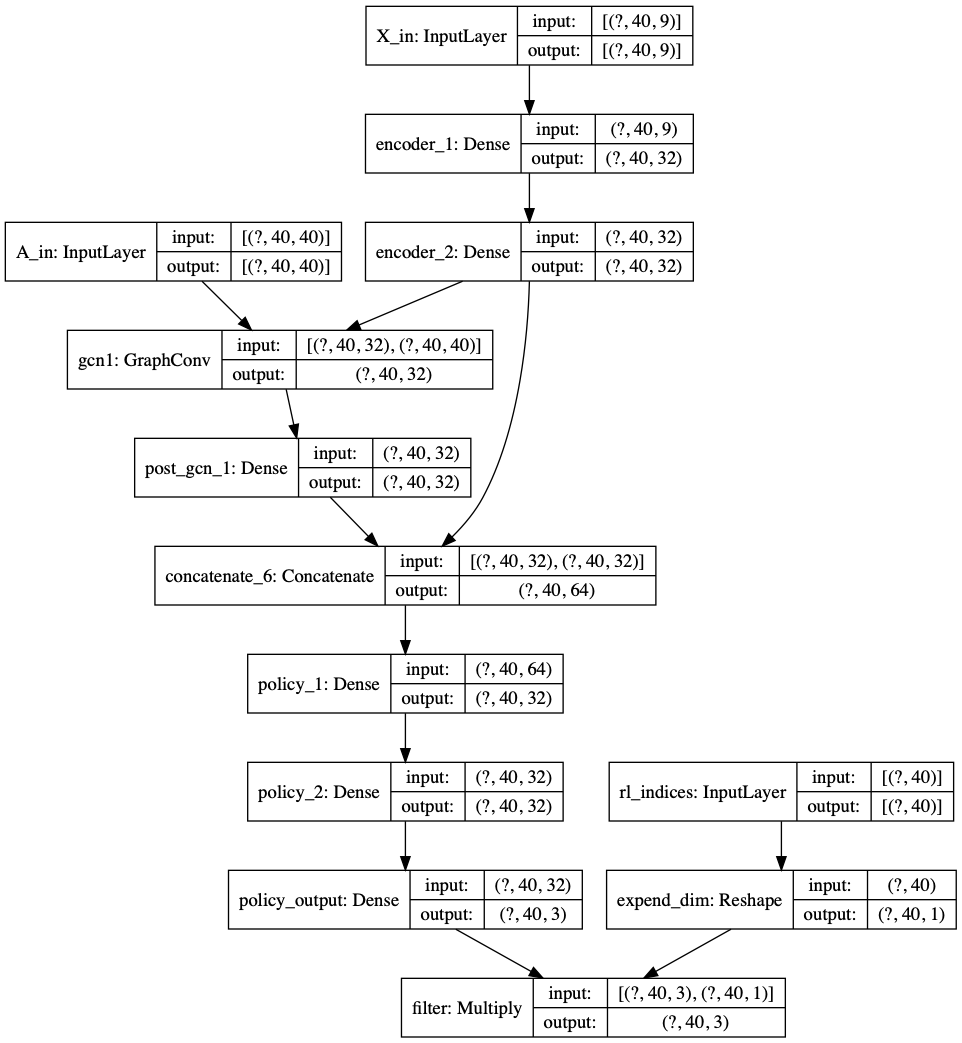

In [24]:
from tensorflow.keras.layers import Input, Dense, Lambda, Multiply, Reshape, Flatten, Concatenate
class GraphicQNetworkKeras2():
    def __init__(self, N,F, obs_space, action_space, num_outputs=3, model_config=None, name='graphic_policy_keras'):
        self.obs_space = obs_space
        self.action_space = action_space
        self.num_outputs = num_outputs
        self.name = name
        self.base_model = self.build_model(N,F,num_outputs)

    def build_model(self,N,F,num_outputs):
        
        X_in = Input(shape=(N,F), name='X_in')
        A_in = Input(shape=(N,N), name='A_in')
        RL_indice = Input(shape=(N), name='rl_indices')
        
        ### Encoder
        x = Dense(32,activation='relu',name='encoder_1')(X_in)
        x = Dense(32,activation='relu',name='encoder_2')(x)
        


        ### Graphic convolution

        x1 = GraphConv(32, activation='relu',name='gcn1')([x, A_in])
        x1 = Dense(32,activation='relu',name='post_gcn_1')(x1)
        
        
        x2 = GraphConv(32, activation='relu',name='gcn2')([x1, A_in])
        x2 = Dense(32,activation='relu',name='post_gcn_2')(x2)
        
        
        

        ###  Action and filter
        x3 = Concatenate()([x,x1])
        x3 = Dense(32, activation='relu',name='policy_1')(x3)
        x3 = Dense(32, activation='relu',name='policy_2')(x3)
        
        x3 = Dense(num_outputs, activation='linear',name='policy_output')(x3)
        mask = Reshape((N,1),name='expend_dim')(RL_indice)
        qout = Multiply(name='filter')([x3,mask])

        model = Model(inputs = [X_in,A_in,RL_indice], outputs=[qout])
        print(model.summary())
        return model
    
    
    
rl_model = GraphicQNetworkKeras2(N,F, obs_space, act_space)
plot_model(rl_model.base_model,show_shapes=True)

In [ ]:
class GraphicQNetworkKeras2():
    def __init__(self, N,F, obs_space, action_space, num_outputs=3, model_config=None, name='graphic_policy_keras'):
        self.obs_space = obs_space
        self.action_space = action_space
        self.num_outputs = num_outputs
        self.name = name
        self.base_model = self.build_model(N,F,num_outputs)

    def build_model(self,N,F,num_outputs):
        
        X_in = Input(shape=(N,F), name='X_in')
        A_in = Input(shape=(N,N), name='A_in')
        RL_indice = Input(shape=(N), name='rl_indices')
        
        ### Encoder
        x = Dense(32,activation='relu',name='encoder_1')(X_in)
        x = Dense(32,activation='relu',name='encoder_2')(x)
        


        ### Graphic convolution

        x1 = GraphConv(32, activation='relu',name='gcn1')([x, A_in])
        x1 = Dense(32,activation='relu',name='post_gcn_1')(x1)
        
        
        x2 = GraphConv(32, activation='relu',name='gcn2')([x1, A_in])
        x2 = Dense(32,activation='relu',name='post_gcn_2')(x2)
        
        
    
        ###  Action and filter
        x3 = Concatenate()([x,x1,x2])
        x3 = Dense(32, activation='relu',name='policy_1')(x3)
        x3 = Dense(32, activation='relu',name='policy_2')(x3)
        
        x3 = Dense(num_outputs, activation='linear',name='policy_output')(x3)
        mask = Reshape((N,1),name='expend_dim')(RL_indice)
        qout = Multiply(name='filter')([x3,mask])

        model = Model(inputs = [X_in,A_in,RL_indice], outputs=[qout])
        print(model.summary())
        return model
    
    
    
rl_model = GraphicQNetworkKeras2(N,F, obs_space, act_space)
plot_model(rl_model.base_model)

In [ ]:
processed

In [ ]:
predicted = rl_model.base_model.predict(processed)

In [ ]:
predicted.shape

In [ ]:
predicted

In [ ]:
action_batch

In [ ]:
fake_true = np.ones([10,40,3])

In [ ]:
predicted.shape

In [ ]:
from tensorflow.keras.losses import Huber
import tensorflow as tf
import sys
tf.__version__

In [ ]:
from rl.policy import Policy
class greedy_q_policy(Policy):
    def select_action(self,q_vals):
        action = None
        mask = np.any(q_vals, axis=1)
        if mask.sum() > 0:
            action = q_vals[mask,:].argmax(1)
        return action

class random_obs_policy(Policy):
    def select_action(self,observation):
        action = None
        _,_,mask = observation
        num_agent = mask.sum().astype(int)
        if num_agent>0:
            action = np.random.choice(np.arange(3),num_agent)
        return action

class eps_greedy_q_policy(Policy):
    def __init__(self, eps=.1):
        super(eps_greedy_q_policy, self).__init__()
        self.eps = eps

    def select_action(self,q_vals):
        action = None
        mask = np.any(q_vals, axis=1)
        num_agent = mask.sum().astype(int)
        if num_agent>0:
            if np.random.uniform() < self.eps:  # choose random action
                action = np.random.choice(np.arange(3),num_agent)
            else:
                action = q_vals[mask,:].argmax(1)
        return action

## Assemble dqn

In [ ]:
from agents.memory import CustomerSequentialMemory
memory_buffer = CustomerSequentialMemory(limit=5000, window_length=1)


for obs,a, r, temin in zip(training_data['state'],training_data['action'], training_data['reward'], training_data['done']):
    if isinstance(a,np.ndarray):
        memory_buffer.append(obs,a,r,temin)

In [ ]:
test_policy = greedy_q_policy()
start_policy = random_obs_policy()
train_policy = eps_greedy_q_policy()

In [ ]:
from agents.dqn import DQNAgent
multi_input_processor = Jiqian_MultiInputProcessor(3)
my_dqn = DQNAgent(processor= multi_input_processor,
                  model = rl_model.base_model, 
                  policy = train_policy,
                  test_policy=test_policy,
                  nb_total_agents = 40, 
                  nb_actions = 3, 
                  memory = memory_buffer,
                  nb_steps_warmup=10)

optimizer = tf.keras.optimizers.Adam(0.001)

my_dqn.compile(optimizer)

In [ ]:
import tensorflow as tf
# import tf.keras.callbacks.CallbackList
tf.__version__

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import json

file = './logs/training_hist.txt'
with open(file,'rb') as f:
    data = json.load(f)

losses = data['loss']
rewards = data['episode_reward']

plt.figure()
plt.plot(np.arange(len(losses)),losses)
plt.title('Loss vs episode')
plt.savefig('./figures/loss.png',dpi=300)


plt.figure()
plt.plot(np.arange(len(rewards)),rewards)
plt.title('rewards vs episode')
plt.savefig('./figures/rewards.png',dpi=300)

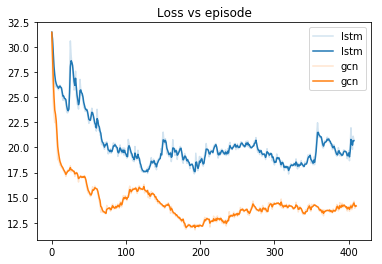

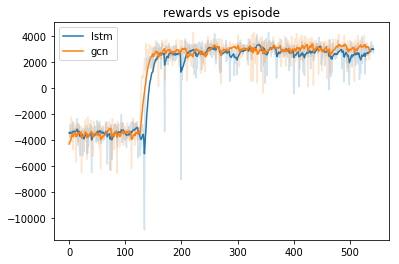

In [58]:
import json
import matplotlib.pyplot as plt
import numpy as np

def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

def plot_training(logdir,loss_smooth_weight=0.5,reward_smooth_weight=0.85):
    # data_file = './logs/training_hist.txt'
    import glob
    data_files = glob.glob(logdir+'*training_hist.txt')
#     print(data_files)
    losses = []
    losses_smoothed = []
    rewards = []
    rewards_smoothed = []
    names = []
    for data_file in data_files:

        with open(data_file,'rb') as f:
            data = json.load(f)
        names.append(data_file.split('/')[-1].split('_')[0])
        
        
        loss = np.array(data['loss'])
        reward = np.array(data['episode_reward'])
        loss = loss[~np.isnan(loss)] #drop nan for smoothing
        
        loss_smoothed = smooth(loss, loss_smooth_weight)
        reward_smoothed = smooth(reward,reward_smooth_weight)
        
        losses.append(loss)
        rewards.append(reward)
        
        losses_smoothed.append(loss_smoothed)
        rewards_smoothed.append(reward_smoothed)


    plt.figure()
    for (loss,loss_smoothed,name) in zip(losses,losses_smoothed,names):
        p = plt.plot(np.arange(len(loss)),loss,label=name,alpha=0.2)
        plt.plot(np.arange(len(loss_smoothed)),loss_smoothed,label=name,c=p[0].get_color())
    plt.legend()
    plt.title('Loss vs episode')
#     plt.savefig('./figures/loss.png',dpi=300)

    plt.figure()
    for (reward,reward_smoothed,name) in zip(rewards,rewards_smoothed,names):
        
        p = plt.plot(np.arange(len(reward)),reward,alpha=0.2)
        
        plt.plot(np.arange(len(reward_smoothed)),reward_smoothed,label=name,c=p[0].get_color())
    plt.legend()
    plt.title('rewards vs episode')
#     plt.savefig('./figures/rewards.png',dpi=300)
    
plot_training('./logs/',0.5,0.85)
              